In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
from sklearn.metrics import average_precision_score
from sklearn.svm import SVC

from pathlib import Path
from tqdm.auto import tqdm
from skimage.transform import resize

import matplotlib
import matplotlib.pyplot as plt

import random

import itertools
from collections import Counter
from sklearn.cluster import KMeans

%matplotlib inline

2024-04-20 09:29:54.771247: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-20 09:29:55.445723: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df =  pd.read_csv("/media/rafael/Dados/04-DataSet/05-Imagens/roupas/data//fashion.csv", index_col = 0)

In [3]:
df.head()

,Gender,Category,SubCategory,ProductType,Colour,Usage,ProductTitle,Image,ImageURL
ProductId,,,,,,,,,
42419,Girls,Apparel,Topwear,Tops,White,Casual,Gini and Jony Girls Knit White Top,42419.jpg,http://assets.myntassets.com/v1/images/style/p...
34009,Girls,Apparel,Topwear,Tops,Black,Casual,Gini and Jony Girls Black Top,34009.jpg,http://assets.myntassets.com/v1/images/style/p...
40143,Girls,Apparel,Topwear,Tops,Blue,Casual,Gini and Jony Girls Pretty Blossom Blue Top,40143.jpg,http://assets.myntassets.com/v1/images/style/p...
23623,Girls,Apparel,Topwear,Tops,Pink,Casual,Doodle Kids Girls Pink I love Shopping Top,23623.jpg,http://assets.myntassets.com/v1/images/style/p...
47154,Girls,Apparel,Bottomwear,Capris,Black,Casual,Gini and Jony Girls Black Capris,47154.jpg,http://assets.myntassets.com/v1/images/style/p...


In [4]:
image_paths = Path('/media/rafael/Dados/04-DataSet/05-Imagens/roupas/data/').rglob('*.jpg')
image_paths = sorted(image_paths)
image_paths[:5]

[PosixPath('/media/rafael/Dados/04-DataSet/05-Imagens/roupas/data/Apparel/Boys/Images/images_with_product_ids/10054.jpg'),
 PosixPath('/media/rafael/Dados/04-DataSet/05-Imagens/roupas/data/Apparel/Boys/Images/images_with_product_ids/10649.jpg'),
 PosixPath('/media/rafael/Dados/04-DataSet/05-Imagens/roupas/data/Apparel/Boys/Images/images_with_product_ids/10671.jpg'),
 PosixPath('/media/rafael/Dados/04-DataSet/05-Imagens/roupas/data/Apparel/Boys/Images/images_with_product_ids/12840.jpg'),
 PosixPath('/media/rafael/Dados/04-DataSet/05-Imagens/roupas/data/Apparel/Boys/Images/images_with_product_ids/12844.jpg')]

In [5]:
print(len(image_paths))

2906


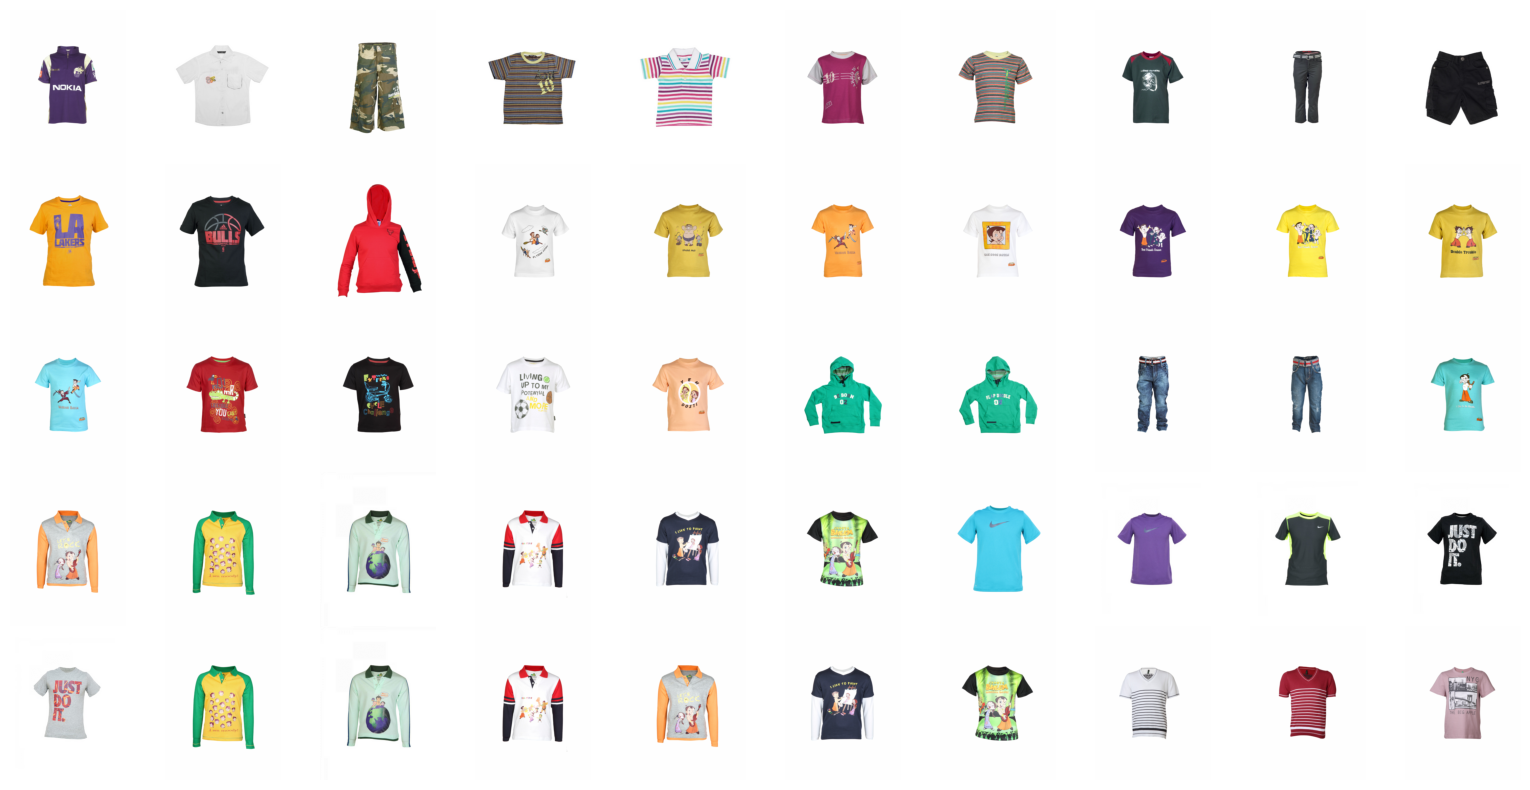

In [6]:
fig, axes = plt.subplots(5, 10, figsize=(20, 10))
for ax, image_path in zip(axes.flatten(), image_paths):
    image_np = plt.imread(image_path)
    image_np = resize(image_np, (400, 300))
    ax.imshow(image_np)
    ax.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)

https://www.kaggle.com/models/google/experts-bit/tensorFlow2/r50x1-in21k-consumer-goods/1?tfhub-redirect=true

!pip install kagglehub -q

In [27]:
model = hub.KerasLayer("https://tfhub.dev/google/experts/bit/r50x1/in21k/consumer_goods/1")

In [39]:
nq = 20  # number of queries
ndb = 500  # number of samples in the database

image_paths

selected_image_paths = random.sample(image_paths, ndb + nq)
db_image_paths = selected_image_paths[:ndb]
q_image_paths = selected_image_paths[-nq:]
q_image_paths[:5]

[PosixPath('/media/rafael/Dados/04-DataSet/05-Imagens/roupas/data/Apparel/Boys/Images/images_with_product_ids/31090.jpg'),
 PosixPath('/media/rafael/Dados/04-DataSet/05-Imagens/roupas/data/Footwear/Men/Images/images_with_product_ids/23849.jpg'),
 PosixPath('/media/rafael/Dados/04-DataSet/05-Imagens/roupas/data/Footwear/Women/Images/images_with_product_ids/46615.jpg'),
 PosixPath('/media/rafael/Dados/04-DataSet/05-Imagens/roupas/data/Apparel/Girls/Images/images_with_product_ids/38342.jpg'),
 PosixPath('/media/rafael/Dados/04-DataSet/05-Imagens/roupas/data/Apparel/Boys/Images/images_with_product_ids/38941.jpg')]

In [40]:
def load_image(path):
    """
    Carrega a imagem, faz o ajuste, converte a matrix para float e expande para 4D
    """
    image_data = tf.io.read_file(path)
    image = tf.image.decode_image(image_data, channels=3, expand_animations=False)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=0)
    return image

def resize_images(images):
    """
    Coloca todas as imagens no mesmo formato
    """
    return tf.image.resize(images, (512, 512), preserve_aspect_ratio=True)

def l2_normalize(feature_vector):
    """
    Aplica a normalização no matriz
    """
    return tf.math.l2_normalize(feature_vector, axis=1)

def extract_features(image_paths, model):
    """
    Converte a imagem para um tensor.  Extrai as caracteristicas da imagem 1
    """
    db = list(map(str, image_paths))
    db = tf.data.Dataset.from_tensor_slices(db)
    db = db.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    db = db.map(resize_images, num_parallel_calls=tf.data.AUTOTUNE)
    db = db.prefetch(5)

    features = db.map(model)
    features = features.map(l2_normalize)

    total = len(features)
    features = features.as_numpy_iterator() 
    features = tqdm(features, total=total)  
    features = list(features)
    features = np.concatenate(features)
    return features

In [41]:
db_features_model = extract_features(db_image_paths, model)

  0%|          | 0/500 [00:00<?, ?it/s]

2024-04-20 10:17:51.492685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [42]:
queries_features_model = extract_features(q_image_paths, model)

  0%|          | 0/20 [00:00<?, ?it/s]

2024-04-20 10:18:03.214542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [43]:
queries_features_model.shape, db_features_model.shape

((20, 2048), (500, 2048))

In [44]:
scores = queries_features_model.dot(db_features_model.T)
scores.shape

(20, 500)

In [45]:
nq, ndb = scores.shape
print(nq)
print(ndb)

20
500


In [46]:
k = 5 
sorted_scores = scores.argsort(axis=1)[:, ::-1]  # ordenado por linha
print(sorted_scores)

[[ 65 370  59 ...  63 433 337]
 [155 279 411 ... 330 199  93]
 [355 490 133 ... 470 460 349]
 ...
 [227  19 328 ... 345 286 118]
 [483 372 377 ... 461 491 349]
 [ 83 375 109 ... 165 168  93]]


In [47]:
topk = sorted_scores[:, :k]  # **índices** das principais imagens para cada linha
print(topk)

[[ 65 370  59 239 407]
 [155 279 411  71 303]
 [355 490 133 112 377]
 [113 128 207  11 451]
 [ 97  42 401 488 381]
 [396 196 412 431 497]
 [464 375 122 446 176]
 [386 313 472 136 110]
 [421 108 117 473 121]
 [368 444 182 458   2]
 [493 308 426 174 389]
 [455 100   1 268 227]
 [ 84  44 101 448 172]
 [  7 124 415 212 429]
 [443  45 361  99 464]
 [444 182 368 280 297]
 [182 378 280 368  25]
 [227  19 328  74 247]
 [483 372 377 453 159]
 [ 83 375 109 206 296]]


In [48]:
topk_scores = np.stack([scores[i, topk[i]] for i in range(nq)])  # get topk scores (comprehensible version)
print(topk_scores)

[[0.99709654 0.9046405  0.8991844  0.8991844  0.8976531 ]
 [0.9397703  0.9350983  0.9299209  0.92848873 0.8993643 ]
 [0.90609753 0.8742716  0.87200475 0.8719267  0.8693446 ]
 [0.93918663 0.9183255  0.9176323  0.9133027  0.9027817 ]
 [0.9455719  0.90049964 0.89938056 0.89380944 0.89380944]
 [0.85782564 0.8541024  0.84424996 0.8384355  0.8352264 ]
 [0.9398128  0.9364555  0.9336209  0.9322809  0.9313977 ]
 [0.9478773  0.8772088  0.86766756 0.86710864 0.86561406]
 [0.9670858  0.9441523  0.935872   0.9265199  0.9232716 ]
 [0.91615045 0.8885296  0.8861412  0.8827929  0.86215854]
 [0.93921477 0.9189795  0.9126805  0.9104772  0.898244  ]
 [0.91803    0.9124483  0.8865874  0.87911105 0.8612524 ]
 [0.9020436  0.89463174 0.89463174 0.89361423 0.88246304]
 [0.8855953  0.88534343 0.88165146 0.87980044 0.8747901 ]
 [0.9496333  0.93689185 0.92837614 0.9244657  0.9239707 ]
 [0.90300363 0.8932291  0.8925948  0.8855922  0.88293934]
 [0.91191405 0.90109    0.8796635  0.87249786 0.8716083 ]
 [0.8558558  0

In [49]:
def unpad_image(image_np):
    # remove espaços em branco
    image_np = np.stack([image_np, image_np, image_np], axis=-1) if image_np.ndim < 3 else image_np
    rr, cc = np.nonzero((image_np != 255).any(axis=2))
    y0, y1 = rr.min(), rr.max()
    x0, x1 = cc.min(), cc.max()
    return image_np[y0:y1+1, x0:x1+1]

def show_images(paths, figsize=None):
    n_images = len(paths)
    fig, axes = plt.subplots(1, n_images, figsize=figsize)
    for ax, path in zip(axes, paths):
        image_np = plt.imread(path)
        image_np = unpad_image(image_np)
        image_np = resize(image_np, (363, 266))
        ax.imshow(image_np)
        ax.set_xticks([])
        ax.set_yticks([])

    return fig

First line are the queries 



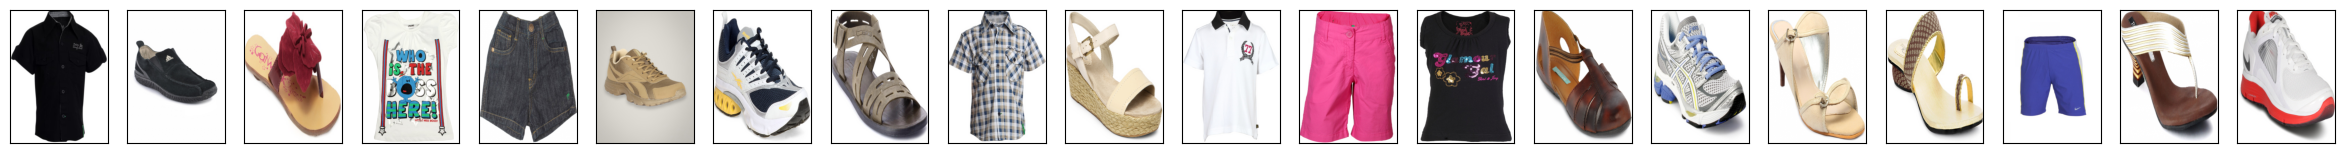

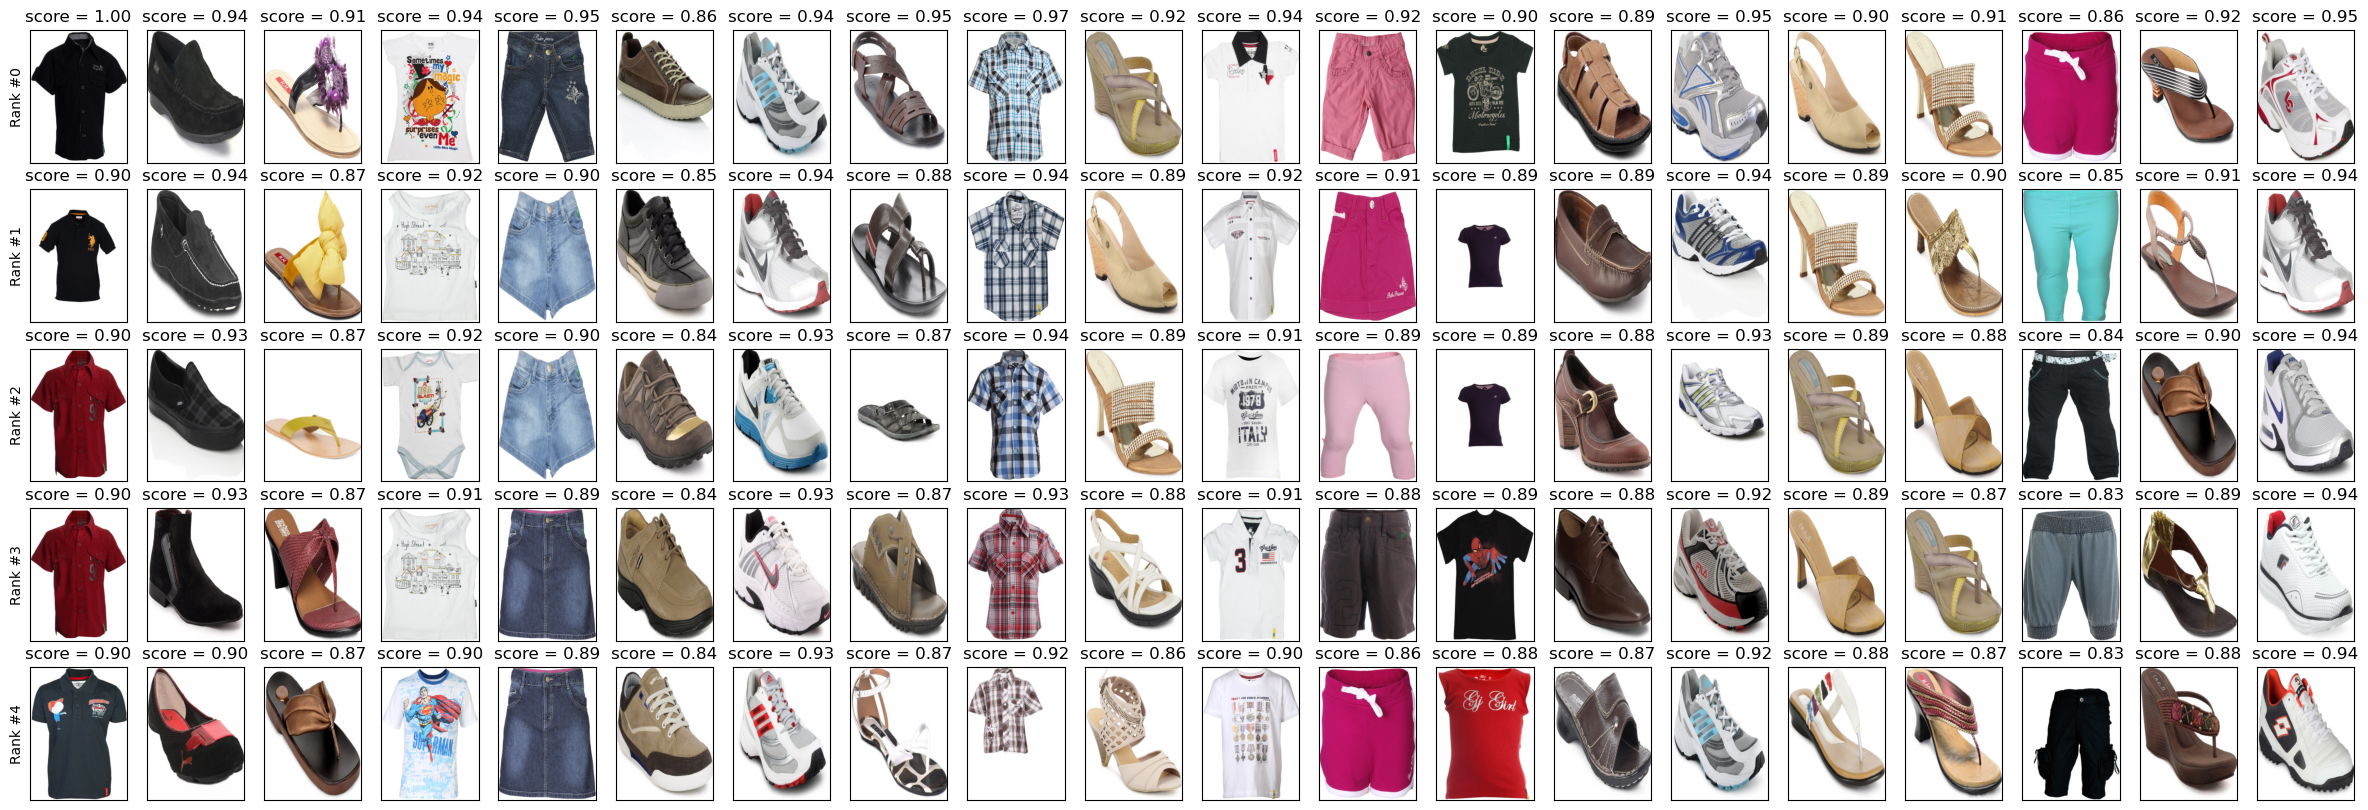

In [50]:
print("First line are the queries \n")
# show queries
fig = show_images(q_image_paths, figsize=(1.5*nq, 5))

# show topk similar 
fig, axes = plt.subplots(k, nq, figsize=(fig.get_figwidth(), 2*k))
for j in range(k):
    axes[j, 0].set_ylabel(f'Rank #{j}')
    for i in range(nq):
        image_np = plt.imread(db_image_paths[topk[i, j]])
        image_np = unpad_image(image_np)
        image_np = resize(image_np, (363, 266))
        axes[j, i].imshow(image_np)
        axes[j, i].set_title('score = {:.2f}'.format(topk_scores[i, j]))
        axes[j, i].set_xticks([])
        axes[j, i].set_yticks([])

cosseno de similaridade